<a href="https://colab.research.google.com/github/nickwinters1/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

It may be helpful to use PCA to reduce the dimensions of your data first in order to obtain --but then again, maybe not. I dunno, you're the data scientist, you tell me.🤪 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler 

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [11]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


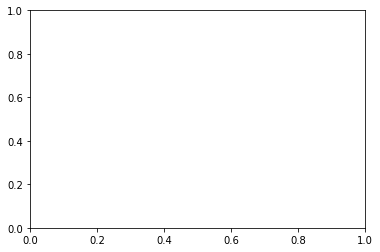

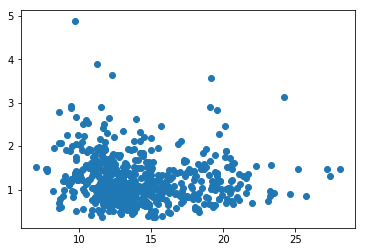

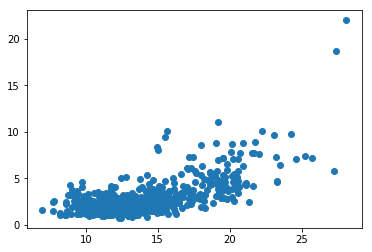

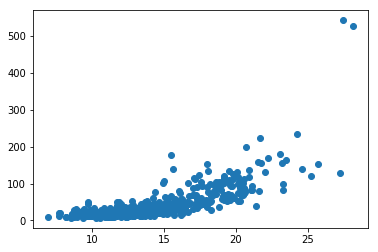

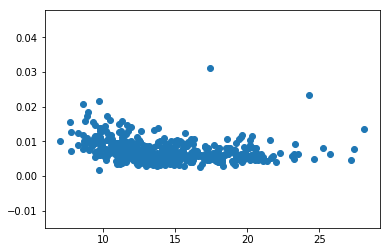

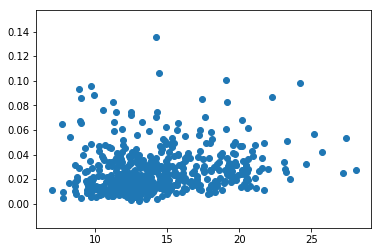

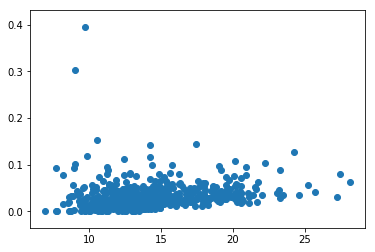

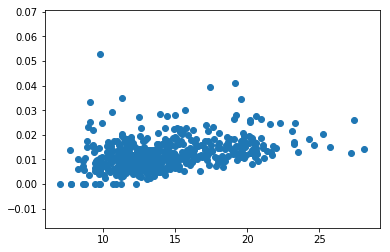

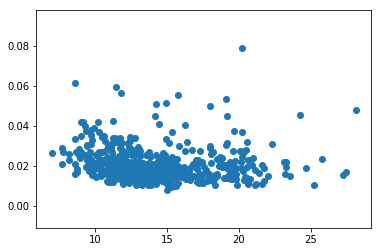

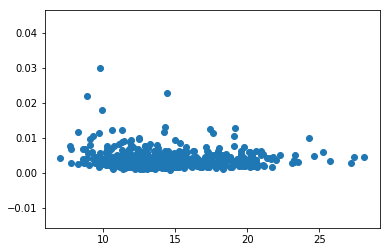

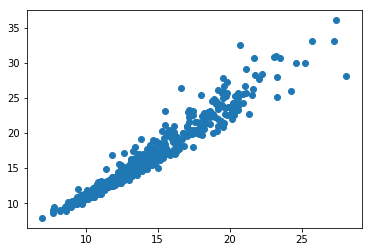

In [24]:
import seaborn as sns
import itertools
cols = df.columns[1:-1]
combs = list(itertools.product(cols, cols[1:]))
fig, ax = plt.subplots()
for col_set in combs[10:20]:
  plt.figure()
  x_col, y_col = list(col_set)
  x = df[x_col]
  y = df[y_col]
  plt.scatter(x,y)

In [20]:
from sklearn.preprocessing import StandardScaler
features = df.columns[1:-1]
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)
len(features)

30

<BarContainer object of 30 artists>

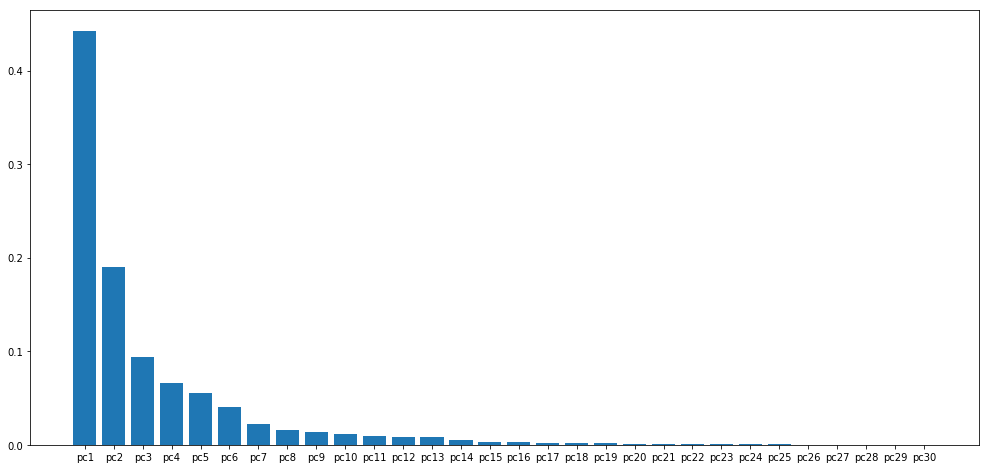

In [22]:
from sklearn.decomposition import PCA
import statistics as stat
pca = PCA(n_components = 30)
principalComponents = pca.fit_transform(x)
labels = ['pc' + str(num) for num in range(1,31)]
principalComp = pd.DataFrame(data = principalComponents,
                            columns = labels)
std_devs = [stat.stdev(principalComp[col].values) for col in labels]
variances = [std**2 for std in std_devs]
sum_var = sum(variances)
prop_varex = [(variance/sum_var) for variance in variances]
fig = plt.figure(figsize = (17,8))
fig.add_axes()
ax1=fig.add_subplot(111)
ax1.bar(x=labels, height=prop_varex)

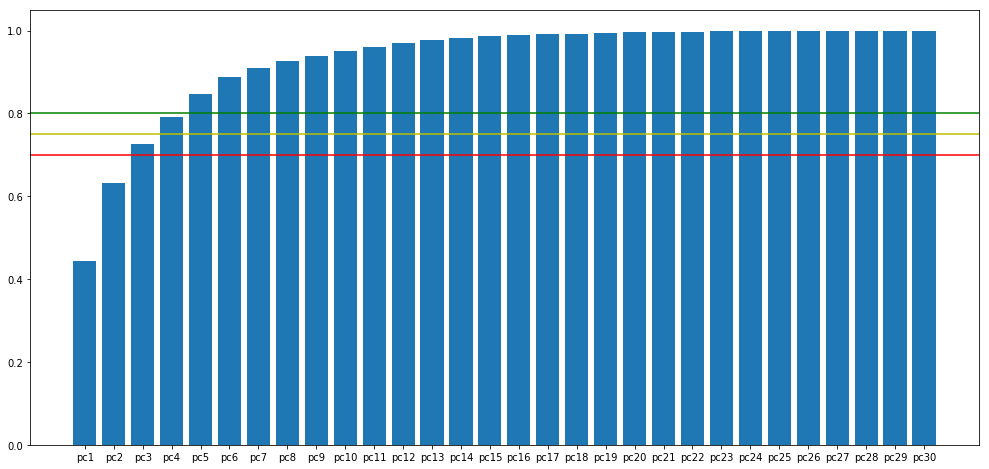

In [25]:
j=0
cum_varex=np.zeros(30)
while j < len(variances):
  cum_varex[j] = sum(prop_varex[:j+1])
  j+=1
  
fig = plt.figure(figsize = (17,8))
fig.add_axes()
ax2=fig.add_subplot(111)
ax2.bar(x=labels, height=cum_varex)
ax2.axhline(0.7, color='r')
ax2.axhline(0.75, color='y')
ax2.axhline(0.8, color='g')

# You take it from here!

See what you can come up with. You have all the know-how! 

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to do PCA on this data to see if that helps you find distinct linearly-separable clusters.
  - (In the real world, truly linearly-separable clusters are rare.)
- You might want to use an elbow chart to decide on the number of clusters to use.
- You might want to use a scree plot to decide how many principal components to include in your clustering.
- You might want to standardize your data before PCA (If you decide to use PCA). 

## Manage your time and don't spend it all on data exploration or something like that. You got this!

In [0]:
##### Your Code Here #####

# Stretch Goal:

Once you are satisfied with your clustering, go back and add back in the labels from the original dataset to check how accurate your clustering was. Remember that this will not be a possibility in true unsupervised learning, but it might be a helpful for your learning to be able to check your work against the "ground truth". Try different approaches and see which one is the most successful and try understand why that might be the case. If you go back and try different methods don't ever include the actual "diagnosis" labels in your clustering or PCA.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.